# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  
https://www.boxcontrol.net/write-simple-currency-converter-in-python.html  

## Todo
- Bug somewhere, need to figure out why alg skipped so many stocks
- Need currency conversion at the specified date... take an average
- Try and merge other currencies into USD columns? Might increase # stocks by a lot
- Need to try and fix some columns, like Revenue USD Mil
- Need to check out bad stocks that were strongly predicted to be good, there's many

In [4]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
from forex_python.converter import CurrencyRates
import datetime
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [27]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")

#tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
#tickers = tickers.loc[tickers['MarketCap']>1e6]  #exclude stocks with small market cap
tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


## Get Data

In [40]:
############################################# Helper Functions #############################################
#############################################                  #############################################
#simple progress bar
def progress_bar(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item

#small helper function for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS'), pd.date_range(date, periods=1, freq='BM')

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock,current_date):
    ds = current_date.split('-')
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    mean_current_price = DataReader(stock, 'yahoo', first_current, last_current)['Adj Close'].mean()
    mean_future_price = DataReader(stock, 'yahoo', first_future, last_future)['Adj Close'].mean()
    mean_past_price = DataReader(stock, 'yahoo', first_past, last_past)['Adj Close'].mean()
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price, mean_current_price

def clean_data(d):
    #delete annoying repeated columns
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    
    #convert commas to dots in relevant columns
    for c in d.columns:
        try:
            d[c]=d[c].str.replace(',','.')
        except:
            pass
    return d

#convert currency values into USD
def convert_currency(values,date):
    currencies = ['AED','ARS','AUD','BRL','CAD','CHF','CLP','CNY','COP','CZK','EUR','GBP','HKD','ILS','INR','JPY','KRW','MXN','OMR','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR']
    date = date.split("-")
    year, month = int(date[0]), int(date[1])
    for c in currencies:
        mask = values.index.str.contains(c)
        if np.any(mask):
            cr = CurrencyRates()
            values.loc[values.index[mask]] *= cr.get_rate(c, 'USD', datetime.datetime(year, month, 1))
            values.index = [col.replace(c, 'USD') for col in values.index]
            return values
    return values

############################################# Main Functions #############################################
#############################################                #############################################

#scrape financial data from Morningstar for a given stock
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    
    #load/scrape data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    
    #clean data
    d = d.transpose().reset_index()
    d = clean_data(d)
    
    #get indices for years of interest
    i_current = np.where(d['index'].str.contains("%d"%year))[0][0]
    i_past = np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
    date_current = d['index'].iloc[i_current]
    date_past = d['index'].iloc[i_past]
    
    #convert data from string to numeric, do currency conversion (if need be), get YOY-ratios
    values_current = convert_currency(pd.to_numeric(d.iloc[i_current], errors='coerce'), date_current)
    values_past = convert_currency(pd.to_numeric(d.iloc[i_past], errors='coerce'), date_past)
    YOY = values_current/values_past
    YOY = YOY.add_suffix(' YOY')
    
    #final dataframe
    d = pd.DataFrame(pd.concat([values_current, YOY])).transpose()
    
    #get Fractional price changes (future/current -> for target and current/past -> for features)
    d['Stock'] = stock
    MFFPC, MPFPC, MP = get_mean_frac_price_change(stock,date_current)
    d['Mean Future Fractional Price Change'] = MFFPC
    d['Mean Past Fractional Price Change'] = MPFPC
    d['Mean Price'] = MP
    return d

###############################################
#Top-level function which compiles all stock data into a single DataFrame
def get_data(ticker_csv,year,true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_data.csv"%(ticker_loc,year))
        skip = np.loadtxt("%s_year%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        print "Loaded data from csv's..."
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],year).columns
        X = pd.DataFrame(columns=cols)                                     #empty dataframe with available columns
        skip = []
        for s in progress_bar(stocks["Symbol"], len(stocks["Symbol"])/10): #main loop, fill dataframe
            try:
                _X = get_stock_financials(s,year)
                if _X.shape[1] >= 1:                                       #only append if alg recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_data.csv"%(ticker_loc,year))
        np.savetxt("%s_year%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    
    #create target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change']>true_threshold)] = 1
    return X, y, skip

Load the data below. This will take a minute.

In [41]:
year = 2015
true_threshold=1.0  #Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
ticker_csv = "csv/wilshire5000.csv"
#ticker_csv = 'csv/nasdaq/Finance.csv'

X, y, skip = get_data(ticker_csv, year, true_threshold)

Couldn't find DataFrame, scraping data from Morningstar...


0.0 0.0999756750182 0.199951350036 0.299927025055 0.399902700073 0.499878375091 0.599854050109 0.699829725128 0.799805400146 0.899781075164 0.999756750182

In [42]:
#Relative class numbers
print "Number of True cases = %d"%len(y[y==1])
print "Number of False cases = %d"%len(y[y==0])
print "Total cases = %d"%len(y)

Number of True cases = 1697
Number of False cases = 799
Total cases = 2496


## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [43]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            #X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "!couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

**Deleted** Accounts Payable: NaN fraction = 0.2376
**Deleted** Accounts Payable YOY: NaN fraction = 0.2636
**Deleted** Accounts Receivable: NaN fraction = 0.1102
**Deleted** Accounts Receivable YOY: NaN fraction = 0.1342
**Deleted** Accrued Liabilities: NaN fraction = 0.2192
**Deleted** Accrued Liabilities YOY: NaN fraction = 0.2412
Asset Turnover: NaN fraction = 0.0673
Asset Turnover (Average): NaN fraction = 0.0673
Asset Turnover (Average) YOY: NaN fraction = 0.0905
Asset Turnover YOY: NaN fraction = 0.0905
Book Value Per Share * USD: NaN fraction = 0.0557
Book Value Per Share * USD YOY: NaN fraction = 0.0777
**Deleted** COGS: NaN fraction = 0.2480
**Deleted** COGS YOY: NaN fraction = 0.2660
Cap Ex as a % of Sales: NaN fraction = 0.0986
**Deleted** Cap Ex as a % of Sales YOY: NaN fraction = 0.1266
Cap Spending USD Mil: NaN fraction = 0.0841
**Deleted** Cap Spending USD Mil YOY: NaN fraction = 0.1587
Cash & Short-Term Investments: NaN fraction = 0.0477
Cash & Short-Term Investments Y

In [44]:
X.columns

Index([u'Asset Turnover', u'Asset Turnover (Average)',
       u'Asset Turnover (Average) YOY', u'Asset Turnover YOY',
       u'Book Value Per Share * USD', u'Book Value Per Share * USD YOY',
       u'Cap Ex as a % of Sales', u'Cap Spending USD Mil',
       u'Cash & Short-Term Investments', u'Cash & Short-Term Investments YOY',
       u'EBT Margin', u'Earnings Per Share USD', u'Earnings Per Share USD YOY',
       u'Financial Leverage', u'Financial Leverage (Average)',
       u'Fixed Assets Turnover', u'Free Cash Flow Per Share * USD',
       u'Free Cash Flow Per Share * USD YOY', u'Free Cash Flow USD Mil',
       u'Free Cash Flow USD Mil YOY', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Net Income YOY', u'Free Cash Flow/Sales %',
       u'Mean Future Fractional Price Change',
       u'Mean Past Fractional Price Change', u'Mean Price',
       u'Net Income USD Mil', u'Net Income USD Mil YOY', u'Net Margin %',
       u'Net PP&E', u'Net PP&E YOY', u'Operating Cash Flow USD Mil',
 

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [45]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
X['P/E Ratio'] = X['Mean Price']/X['Earnings Per Share USD']                 
X['P/B Ratio'] = X['Mean Price']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

X['Working Capital Ratio YOY'] = X['Total Assets YOY']/X['Total Liabilities YOY']   
X['P/E Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD YOY']                 
X['P/B Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD YOY']
X['D/E Ratio YOY'] = X['Total Liabilities YOY']/X["Total Stockholders' Equity YOY"] 

columns = X.columns.tolist()
remove = ['Mean Future Fractional Price Change','Stock']
features = [x for x in columns if x not in remove]

#features to include for analysis
#percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %','Cap Ex as a % of Sales']
#ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD',
#          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Financial Leverage']
#other = ['Cash & Short-Term Investments','EBT Margin']
#features = ratios + percentiles + other

#Top features from analysis
#features = feat_imp[0:20].index

In [46]:
X[features].head()

,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,Cash & Short-Term Investments YOY,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
Stock,,,,,,,,,,,,,,,,,,,,,
A,0.44,0.44,0.676923,0.676923,12.36,0.734403,2.43,-98.0,26.78,0.957797,...,55.72,1.139002,2.258356,29.630282,2.876726,0.794688,1.153568,1.268805,1.279754,0.761083
AAI,0.38,0.38,0.974359,0.974359,11.40,1.018060,27.02,-18.0,8.04,1.163531,...,100.00,1.546073,1.643791,0.126457,0.011404,0.608350,0.992864,1.116002,4.256461,0.651449
AAME,0.53,0.53,1.019231,1.019231,5.05,1.018145,0.19,-0.0,4.97,0.961315,...,32.58,0.991177,1.483239,25.086183,0.943837,2.069368,0.995699,1.238390,1.216320,1.013260
AAN,1.24,1.24,0.976378,0.976378,18.50,1.116476,1.90,-61.0,1.40,1.386139,...,51.40,1.032129,2.057613,12.284312,1.235071,0.945525,1.032922,0.466568,0.719705,0.937991
AAON,1.54,1.54,0.968553,0.968553,3.74,1.129909,5.85,-21.0,8.74,0.509027,...,76.84,1.029061,4.317789,27.779792,6.239312,0.301406,1.093696,1.051847,0.977458,0.888510


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [48]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [49]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.45680933852140077

In [50]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
n_iter = 15     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.1,0.5,1],
    'gamma': [0,0.2,0.4,0.8],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.711470978056
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 0.1, 'n_estimators': 1000, 'max_depth': 16, 'gamma': 0.2}


In [51]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[4000],
    'max_depth': [8],
    'min_child_weight': [0.1],
    'colsample_bytree': [0.5],
    'gamma': [0.2],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.712988400246


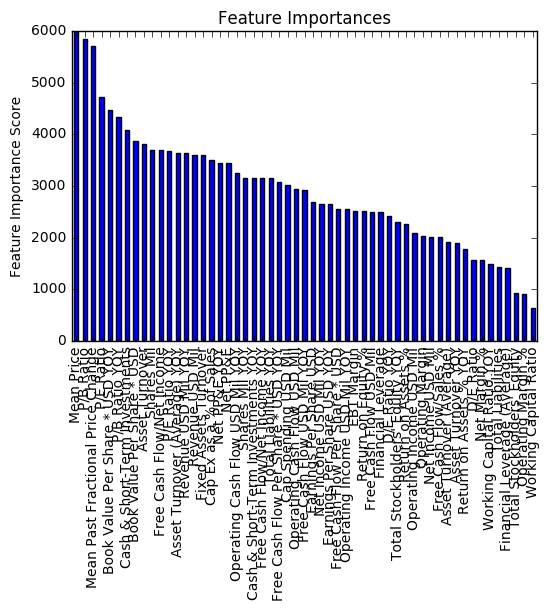

In [52]:
#model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

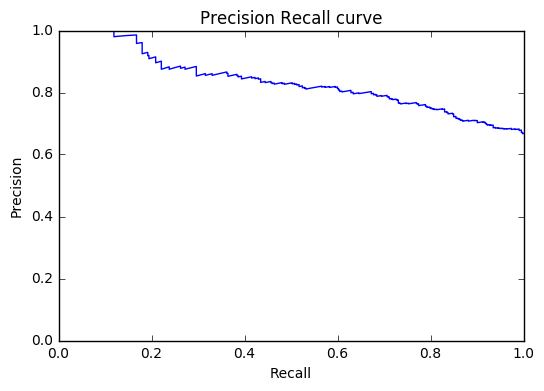

In [53]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

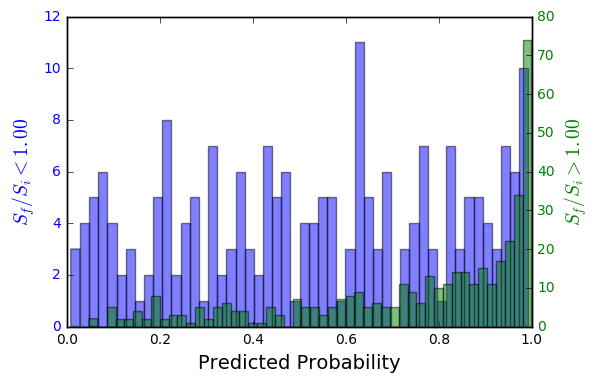

In [54]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.2f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.2f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Extra

In [26]:
stock="AA"
year=2015
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK','OMR','AED']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
#scrape/load data
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]

#load/scrape data
try:
    d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
except:
    webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
    url = URL(webpage)
    f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
    f.write(url.download())
    f.close()
    d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)

#clean data
d = d.transpose().reset_index()

#convert commas to dots in relevant columns
for c in d.columns:
    try:
        d[c]=d[c].str.replace(',','.')
    except:
        pass
#d = clean_data(d)
date = d['index'][0].split('-')
#datetime.datetime(int(date[0]), int(date[1]), 1)
cr = CurrencyRates()



0.76488500000000004

In [55]:
XX = X_test
XX['y_pred'] = y_pred[:,1]
XX['y_test'] = y_test
XX.head()

,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,Cash & Short-Term Investments YOY,...,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY,y_pred,y_test
Stock,,,,,,,,,,,,,,,,,,,,,
UFCS,0.27,0.27,0.990813,0.990813,33.61,1.018060,0.94,-10.0,2.74,0.967668,...,1.291823,10.698471,1.123642,3.426737,0.992864,1.390366,1.347246,1.022996,0.980985,1.0
PVR,0.67,0.67,0.990813,0.990813,0.02,1.018060,2.09,-1.0,5.62,0.967668,...,1.406668,-323043.478261,161521.739130,2.459011,0.992864,1.056349,1.023588,1.022996,0.015457,0.0
FINL,2.17,2.17,0.995413,0.995413,12.31,1.109009,4.84,-88.0,17.60,0.633777,...,3.265839,13.621968,1.881182,0.441338,0.961137,0.875162,0.859959,1.058280,0.269948,0.0
VGR,1.15,1.15,1.026786,1.026786,-1.09,1.535211,0.66,-11.0,32.22,0.753861,...,0.864155,45.017046,-19.411020,-7.361323,0.895437,0.837120,0.826715,0.257170,0.593391,1.0
KBH,0.62,0.62,1.033333,1.033333,17.78,2.195062,0.15,-5.0,11.17,1.481432,...,1.508523,15.651891,0.748262,1.966479,1.002564,8.695743,0.364030,0.992412,0.698608,1.0


In [56]:
XX[(XX['y_test']==0) & (XX['y_pred']>0.9)].index

Index([u'AME', u'TGI', u'CMTL', u'LBTYA', u'TITN', u'CSS', u'SHLM', u'MTSC',
       u'AIRM', u'DO', u'XRAY', u'RSO', u'KMT', u'PRAA', u'CFW', u'CPN',
       u'PPG', u'TTI', u'BWA', u'HCP', u'GPK', u'GTN', u'ALCO', u'CCE', u'SLG',
       u'OCN', u'HURN', u'GGP'],
      dtype='object', name=u'Stock')

In [90]:
colies=['Mean Future Fractional Price Change', 'Mean Past Fractional Price Change']
index = XX[(XX['y_test']==0) & (XX['y_pred']>0.8) & (XX['Mean Past Fractional Price Change']<0.6)].index
X.loc[index]

,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,Cash & Short-Term Investments YOY,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
Stock,,,,,,,,,,,,,,,,,,,,,
CFW,0.02,0.02,1.000000,1.000000,9.25,1.103819,5.70,-12.0,7.85,0.954988,...,14.39,0.951091,1.168088,5.049537,0.316620,5.949270,0.991356,0.178809,0.167777,1.060592
MHGC,0.40,0.40,0.952381,0.952381,-9.48,1.116608,3.24,-7.0,8.17,3.334694,...,-37.39,0.884552,0.727855,21.533333,-0.340717,-3.674512,1.035519,-5.385530,0.371009,1.091738
OCN,0.22,0.22,0.846154,0.846154,8.63,0.670552,2.15,-37.0,3.47,2.210191,...,11.50,0.915605,1.129944,-3.379788,0.771516,7.695652,0.988023,0.617313,0.503775,1.105414


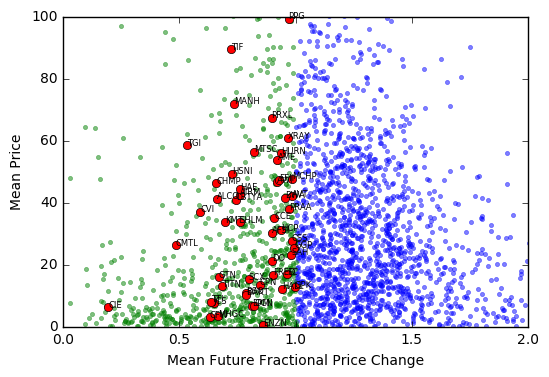

In [101]:
def plot_labels(a,x,y,size,xlo=None,xhi=None,ylo=None,yhi=None):
    arr = a.loc[(a[y]>ylo)&(a[y]<yhi)&(a[x]>xlo)&(a[x]<xhi)]
    arrx, arry, arrnames = arr[x].values, arr[y].values, arr.index.values
    for i in range(len(arrx)):
        plt.text(arrx[i], arry[i], arrnames[i], size=size)

feature_x = "Mean Future Fractional Price Change"
feature = "Mean Price"
plt.plot(X.loc[y==1,feature_x], X.loc[y==1,feature], '.', alpha=0.5)
plt.plot(X.loc[y==0,feature_x], X.loc[y==0,feature], '.', alpha=0.5)

index = XX[(XX['y_test']==0) & (XX['y_pred']>0.8)].index
plt.plot(X[feature_x].loc[index], X[feature].loc[index], 'o')

xlo,xhi,ylo,yhi = 0,2,0,100
plot_labels(X.loc[index],feature_x,feature,6,xlo,xhi,ylo,yhi)
plt.ylim([ylo,yhi])
plt.xlim([xlo,xhi])
plt.xlabel(feature_x)
plt.ylabel(feature)

Testing

In [47]:
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
stock="WFD"
d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
d = d.transpose().reset_index()
#date = d['index'].values
i1,i2 = np.where(d['index'].str.contains("%d"%2015))[0][0], np.where(d['index'].str.contains("%d"%(2015-1)))[0][0]
#ratios = d.iloc[i1].convert_objects(convert_numeric=True)/d.iloc[i2].convert_objects(convert_numeric=True)
#d = pd.DataFrame(ratios).transpose()
#d.insert(0,'Stock',stock)                              #keep stock ticker
#d.insert(1,'Mean Fractional Price Change',get_mean_frac_price_change(stock,date)) #get fractional price change
np.any(d.columns.str.contains("EUR"))
#cols = d.columns[d.columns.str.contains("AUD")]
#d[cols] *= 2
#d[cols] = 2*d[cols]

#d.columns = [c.replace('AUD', 'USD') for c in d.columns]
#d.columns

False

In [ ]:
i1=np.where(d['index'].str.contains("%d"%year))[0][0]
date=d['index'].iloc[i1]
get_mean_frac_price_change("ABCB",date)

In [ ]:
plt.plot(X['Earnings Per Share USD'],X['Mean Fractional Price Change'], '.',alpha=0.05)
plt.xlim([-5,5])
plt.ylim([0,4])

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [ ]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [ ]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [ ]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [ ]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()

0.7674469
